In [1]:

from datetime import datetime

import torch
from torch.utils.data import DataLoader

from datasets.LabeledImageDataset import LabeledImageDataset
from models.resnet import Resnet18Model
from train import train_classifier
from utils import plot_model_metrics
from utils import reduce_dataset, split_dataset, undersample_dataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

batch_size = 256
dataset = LabeledImageDataset("data/candidates")
dataset = reduce_dataset(dataset, discard_ratio=0.0)
train_dataset, test_dataset = split_dataset(dataset, train_ratio=0.7)
train_dataset = undersample_dataset(train_dataset)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=True, )

model = Resnet18Model(hidden_layers=3, units_per_layer=2048, dropout=0.2,focal_alpha=0.03)

print(f"Dataset: {len(train_dataset):,} training, {len(test_dataset):,} testing")


Device: cuda:0
Dataset: 1,520 training, 6,069 testing


In [2]:
print(model)

Resnet18Model(
  (pretrained_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [3]:
print(f"Training starts {datetime.now().isoformat()}")

Training starts 2025-01-28T21:03:01.387015


In [4]:

model = model.to(device)
model, model_metrics = train_classifier(model, train_loader, test_loader, device,
                                        learning_rate=0.0001,
                                        max_epochs=20,
                                        checkpoint_every=1,
                                        eval_every=1)


Epoch 1 training: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


Train: 1/20: loss:0.004985444946214557


Epoch 1 testing: 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]


Test: 1/20: loss:0.005442182514040421, accuracy:0.47148545407458564, precision:0.09151696195190746, recall:0.9882383241758242, f1:0.1666996168659285, mcc:0.19516106354162707, ece:0.528514546652635, epoch:0


Epoch 2 training: 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]


Train: 2/20: loss:0.004076832400945325


Epoch 2 testing: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s]


Test: 2/20: loss:0.004792327022490402, accuracy:0.6723578858770719, precision:0.13677368574452678, recall:0.9648546476671477, f1:0.23725923288033424, mcc:0.28452117611572475, ece:0.3276421142121156, epoch:1


Epoch 3 training: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


Train: 3/20: loss:0.0032010554568842053


Epoch 3 testing: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


Test: 3/20: loss:0.0052834504943651455, accuracy:0.7188677989755985, precision:0.15550717180946885, recall:0.9594671362134598, f1:0.2651082441458823, mcc:0.3154167775303324, ece:0.2811322019745906, epoch:2


Epoch 4 training: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


Train: 4/20: loss:0.002964932044657568


Epoch 4 testing: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s]


Test: 4/20: loss:0.0033110222041917345, accuracy:0.812676248848987, precision:0.20998784871646234, recall:0.8945005690529987, f1:0.33761634846229344, mcc:0.3751650997046509, ece:0.18732375216980776, epoch:3


Epoch 5 training: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


Train: 5/20: loss:0.002779670952198406


Epoch 5 testing: 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]


Test: 5/20: loss:0.004561399798452233, accuracy:0.7426820758517495, precision:0.16704901984211964, recall:0.964261399004046, f1:0.2819756209738237, mcc:0.3344748299548157, ece:0.2573179230093956, epoch:4


Epoch 6 training: 100%|██████████| 6/6 [00:04<00:00,  1.50it/s]


Train: 6/20: loss:0.002655439544469118


Epoch 6 testing: 100%|██████████| 24/24 [00:15<00:00,  1.52it/s]


Test: 6/20: loss:0.003961337487756585, accuracy:0.7663731583793738, precision:0.1824702599924729, recall:0.954076948378419, f1:0.3048553707964495, mcc:0.35510847147167235, ece:0.23362684063613415, epoch:5


Epoch 7 training: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Train: 7/20: loss:0.00242888981786867


Epoch 7 testing: 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]


Test: 7/20: loss:0.003542664179500813, accuracy:0.7942888179097606, precision:0.19923438304137783, recall:0.934267509451333, f1:0.3263615871104291, mcc:0.3721957823786406, ece:0.20571118034422398, epoch:6


Epoch 8 training: 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]


Train: 8/20: loss:0.0022835153698300323


Epoch 8 testing: 100%|██████████| 24/24 [00:15<00:00,  1.53it/s]


Test: 8/20: loss:0.003947132965549827, accuracy:0.7933077592656538, precision:0.19829664999169536, recall:0.9424200332046695, f1:0.3251286080273139, mcc:0.3734965239644261, ece:0.2066922423740228, epoch:7


Epoch 9 training: 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]


Train: 9/20: loss:0.0021627903721916177


Epoch 9 testing: 100%|██████████| 24/24 [00:15<00:00,  1.54it/s]


Test: 9/20: loss:0.0023426016899369038, accuracy:0.8688798486418049, precision:0.2640288373937747, recall:0.800981904769637, f1:0.39191090897369524, mcc:0.4084975365337737, ece:0.13112015121926865, epoch:8


Epoch 10 training: 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]


Train: 10/20: loss:0.0021749798324890435


Epoch 10 testing: 100%|██████████| 24/24 [00:15<00:00,  1.52it/s]


Test: 10/20: loss:0.0024835185661989576, accuracy:0.8591259136164825, precision:0.251988614237481, recall:0.823725535765977, f1:0.38178619115168666, mcc:0.40289915252497316, ece:0.14087408563743034, epoch:9


Epoch 11 training: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


Train: 11/20: loss:0.0022568929319580397


Epoch 11 testing: 100%|██████████| 24/24 [00:15<00:00,  1.51it/s]


Test: 11/20: loss:0.0022639952755222716, accuracy:0.8681056126266115, precision:0.26200123732256264, recall:0.7999298733673733, f1:0.3917580316440458, mcc:0.40737675802631546, ece:0.13189438668390116, epoch:10


Epoch 12 training: 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]


Train: 12/20: loss:0.001975997215292106


Epoch 12 testing: 100%|██████████| 24/24 [00:15<00:00,  1.51it/s]


Test: 12/20: loss:0.00253869797840404, accuracy:0.8540965268186004, precision:0.24891016474296268, recall:0.849156079665948, f1:0.38160838849228423, mcc:0.4078452940594633, ece:0.1459034721677502, epoch:11


Epoch 13 training: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]


Train: 13/20: loss:0.001819881338936587


Epoch 13 testing: 100%|██████████| 24/24 [00:15<00:00,  1.50it/s]


Test: 13/20: loss:0.003816067832910145, accuracy:0.8095046687960404, precision:0.21123862775095406, recall:0.9273207738039394, f1:0.34000388557287825, mcc:0.38443856867054493, ece:0.1904953314612309, epoch:12


Epoch 14 training: 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]


Train: 14/20: loss:0.0016939255486552913


Epoch 14 testing: 100%|██████████| 24/24 [00:15<00:00,  1.51it/s]


Test: 14/20: loss:0.004208612983347848, accuracy:0.8047126784069981, precision:0.20757953010156446, recall:0.9314193610826736, f1:0.3354427244943852, mcc:0.38086403202004687, ece:0.19528732262551785, epoch:13


Epoch 15 training: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]


Train: 15/20: loss:0.0017717489002582927


Epoch 15 testing: 100%|██████████| 24/24 [00:15<00:00,  1.52it/s]


Test: 15/20: loss:0.002484455253579654, accuracy:0.873679032861418, precision:0.2699534063977381, recall:0.803359536418747, f1:0.40086960028832025, mcc:0.41636750260692823, ece:0.12632096682985625, epoch:14


Epoch 16 training: 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


Train: 16/20: loss:0.0016240964566046994


Epoch 16 testing: 100%|██████████| 24/24 [00:15<00:00,  1.52it/s]


Test: 16/20: loss:0.0029914477296794453, accuracy:0.8502694089548802, precision:0.2411258535566769, recall:0.8481718002857709, f1:0.37138620048417265, mcc:0.3989361199754063, ece:0.14973058986167112, epoch:15


Epoch 17 training: 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]


Train: 17/20: loss:0.001439021803283443


Epoch 17 testing: 100%|██████████| 24/24 [00:15<00:00,  1.50it/s]


Test: 17/20: loss:0.0033266723233585558, accuracy:0.8450493856468692, precision:0.24049354889123378, recall:0.8873229355282374, f1:0.37507937573497957, mcc:0.4088149034967324, ece:0.15495061439772448, epoch:16


Epoch 18 training: 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


Train: 18/20: loss:0.0013900659590338667


Epoch 18 testing: 100%|██████████| 24/24 [00:16<00:00,  1.49it/s]


Test: 18/20: loss:0.006491804864102353, accuracy:0.7472231813996316, precision:0.1687904962256377, recall:0.9469343973020443, f1:0.28529812423044915, mcc:0.33403491511360445, ece:0.2527768189708392, epoch:17


Epoch 19 training: 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]


Train: 19/20: loss:0.001442921735967199


Epoch 19 testing: 100%|██████████| 24/24 [00:16<00:00,  1.50it/s]


Test: 19/20: loss:0.006893110500338177, accuracy:0.7404313061118785, precision:0.16618001756972792, recall:0.9596665233130016, f1:0.2806809761071159, mcc:0.331644993501955, ece:0.2595686943580707, epoch:18


Epoch 20 training: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


Train: 20/20: loss:0.0014598161020937066


Epoch 20 testing: 100%|██████████| 24/24 [00:16<00:00,  1.49it/s]

Test: 20/20: loss:0.00425935954748032, accuracy:0.8232511797882136, precision:0.22016593649783145, recall:0.9064050441517546, f1:0.3515866268187576, mcc:0.3912386303159961, ece:0.17674882089098296, epoch:19


Training ends 2025-01-28T21:09:36.500658
Test accuracy: 0.8232511797882136
Test precision: 0.22016593649783145
Test recall: 0.9064050441517546
Test f1: 0.3515866268187576
Test mcc: 0.3912386303159961


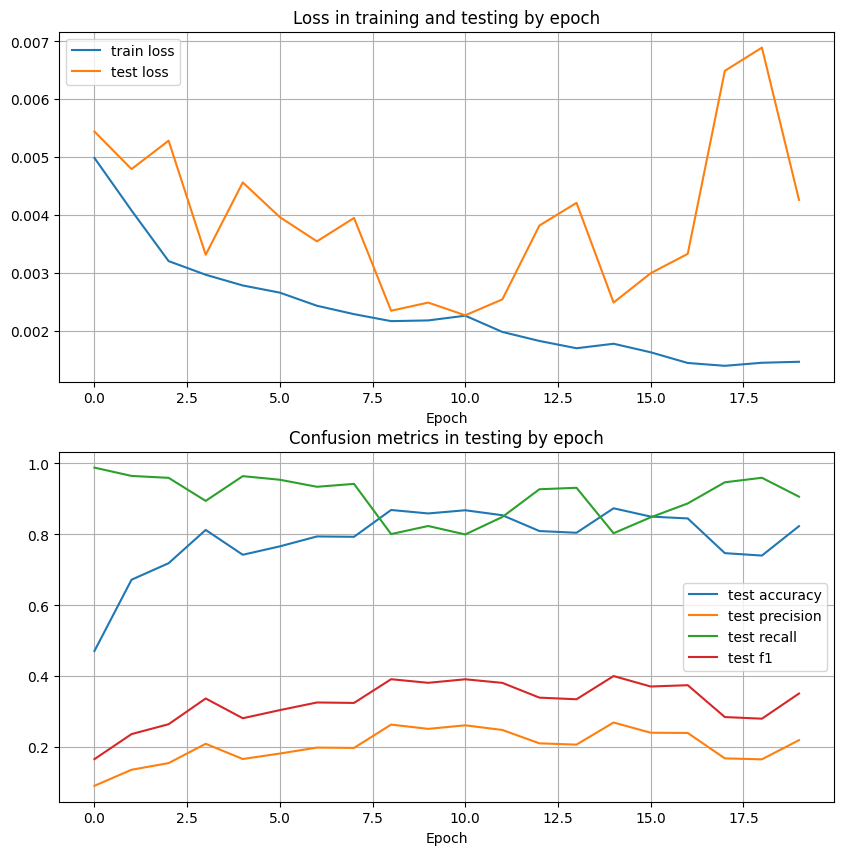

In [5]:

print(f"Training ends {datetime.now().isoformat()}")
for metric in ["accuracy", "precision", "recall", "f1", "mcc"]:
    if len(model_metrics[f"test_{metric}"]) > 0:
        print(f"Test {metric}:", model_metrics[f"test_{metric}"][-1])

plot_model_metrics(model_metrics)

In [6]:
torch.save(model, "model.pickle")